In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("/usr/local/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [10]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("../data/sim") # Set this to your data path
prefix = "rf1"

number_neurons = 4096
number_stimuli = 6
time_range = 100
bin_size = 100e-3

In [11]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtime = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),number_stimuli))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtime[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=number_neurons)

print("Analyzing ...")
nmf = NMF(n_components=number_stimuli)
nmf.fit(data)
y = nmf.transform(data)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...


Analyzing ...


Plotting ...


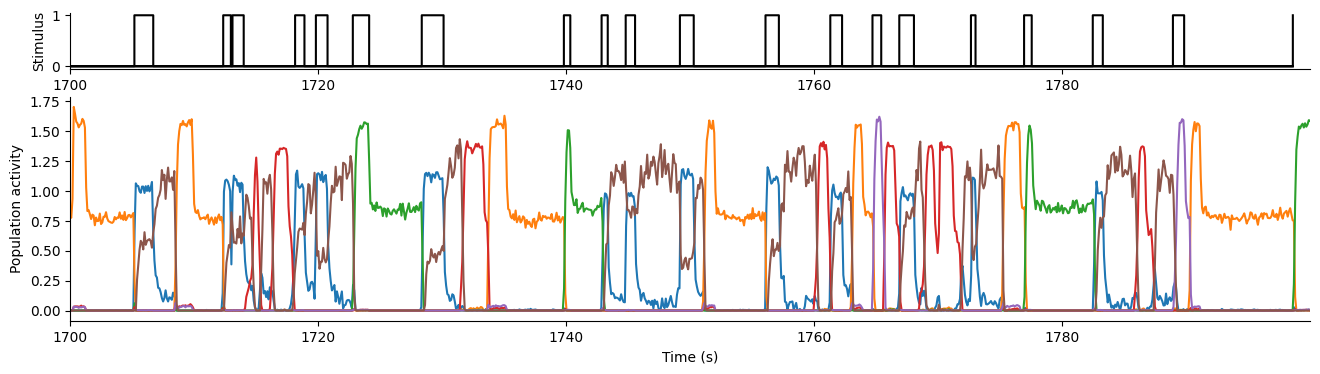

In [12]:
print("Plotting ...")
time = np.linspace(t_start,t_stop,data.shape[0])
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(16,4))
# plt.figure(figsize=(120,4))

ax = plt.subplot(gs[0])
# note that these colors might be out of order due to permutation invariance of NMF 
# which is why we make them black below
order = [0,1,2,3] 
plt.plot(stimtime, stimdata[:,order], color="black")
plt.xlim((t_start,t_stop))
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
sns.despine()

ax = plt.subplot(gs[1])
plt.plot(time, y)
plt.xlim((t_start,t_stop))
plt.xlabel("Time (s)")
plt.ylabel("Population activity")
sns.despine()

In [ ]:
# We can use these components to generate a new rf1.pat file for monitoring
# with open("rf1.pat","w") as f:
#     for comp in nmf.components_[order]:
#         for i,v in enumerate(comp):
#             if v<0.5: continue
#             f.write("%i\n"%i)
#         f.write("\n\n")

In [ ]:
stimtime.shape
data.shape
stimdata[1]

array([0., 0., 1., 0.])

In [65]:
# I have a numpy array time_binned_spike_counts of shape (18000, 4096) that corresponds to 18000 time bins (each with 100ms) of 4096 neurons' activity, the value being the number of spikes of each neuron in each time bin.

# I also have an array stimtime of shape (2338,) that corresponds to all the times one of 4 stimuli was shown to the network. There is also an array stimdata of shape (2338, 4), where at each stimtime there is a binary array of length 4 representing which stimulus if any is being shown represented by theh stimulus' index having the value of 1.

# Write the python code to determine what neurons respond to each of the 4 stimuli. A neuron responds to a stimulus if between 2 seconds and 2.5 seconds after a given stimulus is shown, the frequency of this neuron spiking is higher than 10HzI have a numpy array time_binned_spike_counts of shape (18000, 4096) that corresponds to 18000 time bins (each with 100ms) of 4096 neurons' activity, the value being the number of spikes of each neuron in each time bin.

# I also have an array stimtime of shape (2338,) that corresponds to all the times one of 4 stimuli was shown to the network. There is also an array stimdata of shape (2338, 4), where at each stimtime there is a binary array of length 4 representing which stimulus if any is being shown represented by theh stimulus' index having the value of 1.

# Write the python code to determine what neurons respond to each of the 4 stimuli. A neuron responds to a stimulus if between 2
# seconds and 2.5 seconds after a given stimulus is shown, the frequency of this neuron spiking is higher than 10Hz

# stim_masks = [stimdata[:, i] == 1 for i in range(4)]

# # Constants
# TIME_BIN_DURATION = 0.1  # 100ms
# RESPONSE_START = 20  # 2 seconds in time bins (2 / 0.1 = 20)
# RESPONSE_END = 25  # 2.5 seconds in time bins (2.5 / 0.1 = 25)
# SPIKE_THRESHOLD = 10 * (RESPONSE_END - RESPONSE_START) * TIME_BIN_DURATION  # 10Hz over the total duration

# # 2. Identify relevant time bins for each stimulus
# response_bins = [np.array([range(int(t + RESPONSE_START), int(t + RESPONSE_END)) for t in np.where(mask)[0]]).flatten() for mask in stim_masks]

# # 3. Determine which neurons respond to each stimulus
# responding_neurons = []

# for bins in response_bins:
#     # Sum up the spikes for each neuron in the identified bins
#     spike_counts = np.sum(time_binned_spike_counts[bins], axis=0)
    
#     # Neurons that respond have spike rates > 10Hz during the 2-2.5s after stimulus onset
#     responding = np.where(spike_counts > SPIKE_THRESHOLD)[0]
#     responding_neurons.append(responding)

# # Print neurons that respond to each stimulus
# for i, neurons in enumerate(responding_neurons):
#     print(f"Stimulus {i} has {len(neurons)} responding neurons: {neurons}")

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False,  True,  True, ..., False, False,  True]),
 array([False, False, False, ..., False, False, False])]

# Load and analyze EE weights

In [40]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )
w = w.todense()

Text(0.5, 1.0, 'Weight matrix')

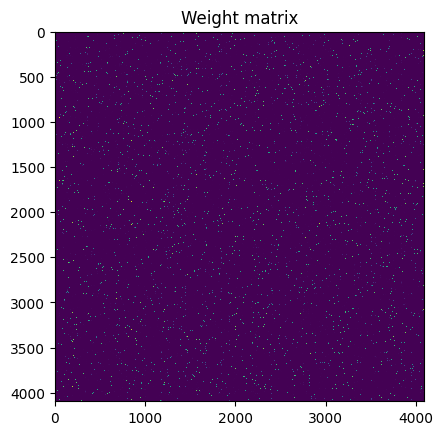

In [42]:
plt.imshow(w,interpolation="none",cmap="viridis")
plt.title("Weight matrix")

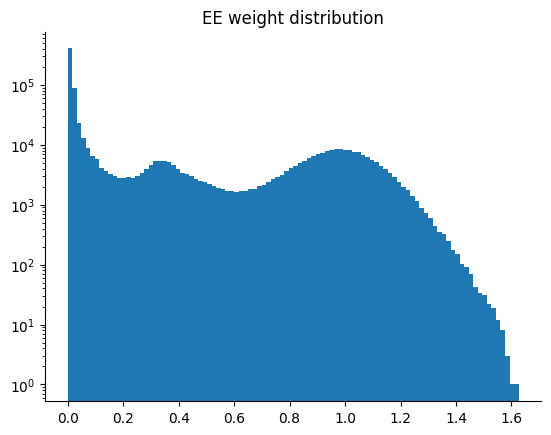

In [9]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [10]:
# Now let's find the cell assemblies
nmf = NMF(n_components=4)
wy = nmf.fit_transform(w)

In [11]:
wy.shape

(4096, 4)

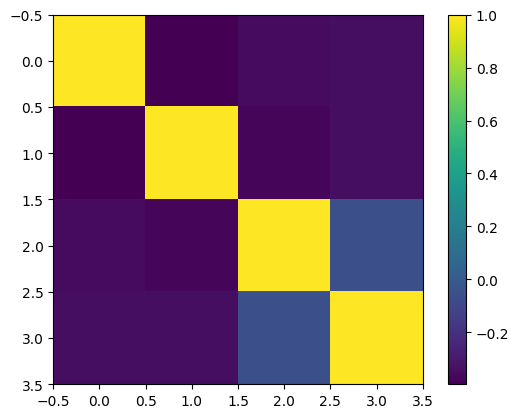

In [12]:
plt.imshow(np.corrcoef(nmf.components_))
plt.colorbar()